# Toy example

In [76]:
using Random
rand_state = 42
Random.seed!(rand_state)

MersenneTwister(42)

To check that everything is working well, we will replicate an example from Murphy (2022). The Python code generating the example has been [open sourced](https://github.com/probml/pyprobml/blob/master/scripts/logreg_laplace_demo.py). The author of the code uses the `bayes_logistic` function to run Bayesian Logistic Regression (BLR) using Laplace approximation (source code available [here](https://bayes-logistic.readthedocs.io/en/latest/_modules/bayes_logistic/bayes_logistic.html#fit_bayes_logistic)). Here we will code up BLR from scratch in Julia programming language. First, let's generate the synthetic dataset used for the example in Murphy (2022).

In [77]:
using CSV
using DataFrames
df = CSV.read("./data/toy_data.csv", DataFrame);
select(df, :y => (x -> map(x -> Int(x), x)) => :y);

For visualization purposes I prefer working with R's `ggplot2`. Fortunately, Julia makes it incredibly easy to work with R packages.

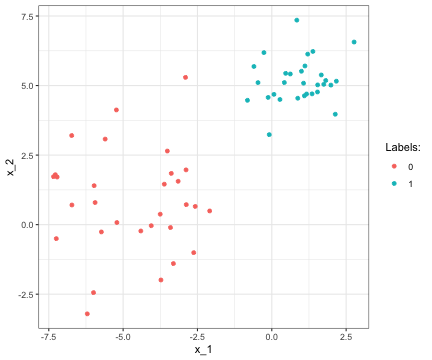

RObject{VecSxp}


In [78]:
# Loading library
using RCall
@rlibrary ggplot2
p = ggplot() +
    geom_point(data=df, aes(x=:x_1, y=:x_2, color=R"factor($df$y)")) +
    scale_color_discrete(name="Labels:") +
    theme_bw()

In [207]:
using LinearAlgebra
include("julia/bayes_logreg.jl");

In [121]:
y = df[:,:y]
X = Matrix(df[:,Not(:y)])
D = size(X)[2] # number of features
N = size(X)[1] # number of observations
σ = 5 # noise
w_0 = zeros(D)
H_0 = UniformScaling(1/(σ^2));

In [81]:
range = 8
step = 0.1
W = expandgrid(-range:step:range,-range:step:range)
N_grid = size(W)[1];

In [145]:
T = 10000
sgd_options = (
    ρ_0=1.0,
    T=T,
    ε=10/T
)
model = bayes_logreg(X,y,w_0,H_0,sgd_options...);
w_map = model.μ
println(model.μ)
println(inv(model.Σ))
∇∇(X,y,model.μ,H_0)

[2.6009946455592954, 1.3696311283884275]
[2.589061029976145 -3.9352839593727027; -3.9352839593727027 7.9786818457600965]


2×2 Matrix{Float64}:
  2.58906  -3.93528
 -3.93528   7.97868

In [ ]:
τ

In [213]:
function arminjo(𝓁, g_t, θ_t, d_t, args, ρ, c=1e-4)
    𝓁(θ_t .+ ρ .* d_t, args...) <= 𝓁(θ_t, args...) .+ c .* ρ .* d_t'g_t
end

function newton(𝓁, θ, ∇𝓁, ∇∇𝓁, args; max_iter=100, τ=1e-5)
    # Intialize:
    converged = false # termination state
    t = 1 # iteration count
    θ_t = θ # initial parameters
    # Descent:
    while !converged && t<max_iter 
        global g_t = ∇𝓁(θ_t, args...) # gradient
        global H_t = ∇∇𝓁(θ_t, args...) # hessian
        converged = all(abs.(g_t) .< τ) && isposdef(H_t) # check first-order condition
        # If not converged, descend:
        if !converged
            d_t = -inv(H_t)*g_t # descent direction
            # Line search:
            ρ_t = 1.0 # initialize at 1.0
            count = 1
            while !arminjo(𝓁, g_t, θ_t, d_t, args, ρ_t) 
                ρ_t /= 2
            end
            θ_t = θ_t .+ ρ_t .* d_t # update parameters
        end
        t += 1
    end
    # Output:
    return θ_t, H_t 
end

newton (generic function with 2 methods)

In [187]:
∇(w_0, w_0, X, y, H_0)

2-element Vector{Float64}:
 -84.32859882859952
 -65.32580422474096

In [208]:
∇∇(w_0, w_0, X, y, H_0)

2×2 Matrix{Float64}:
 197.964      8.61483
   8.61483  235.324

In [206]:
sigmoid([1,0],X)[1:5]

5-element Vector{Float64}:
 0.4341703766522961
 0.794953499070537
 0.6145587833220701
 0.8238877570886679
 0.5180768833613085

In [210]:
1/(5^2)

0.04

In [217]:
newton(nll, w_0, ∇, ∇∇, (w_0=w_0, X=X, y=y, H_0=H_0); max_iter=100)

([3.3748493910870585, 1.3154509477522014], [0.7859086757271295 -0.9761910308690609; -0.9761910308690609 3.211549852868176])

In [123]:
∇∇(X,y,[2.50569067, 1.01050854],H_0)

2×2 Matrix{Float64}:
  1.45772  -2.123
 -2.123     7.04885

In [94]:
nll_grid = - (W*X'y - log.(1 .+ exp.(W*X')) * ones(N))
#nll_grid = [-nll_(W[n,:],w_0,X,y,H_0) for n=1:N_grid]
df_grid = DataFrame(hcat(nll_grid,W), :auto)
p + 
    stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1)) +
    geom_point(aes(x=w_map[1], y=w_map[2]))

RCall.REvalError: REvalError: Fehler in is.finite(x) : 
  nicht implementierte Standardmethode für Typ 'list'
Ruft auf: <Anonymous> ... <Anonymous> -> f -> lapply -> FUN -> f -> check_transformation

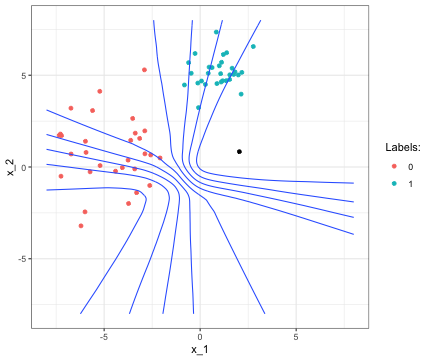

RObject{VecSxp}


In [97]:
nll_grid = [-nll(W[n,:],w_0,X,y,H_0) for n=1:N_grid]
df_grid = DataFrame(hcat(nll_grid,W), :auto)
p + 
    stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1)) +
    geom_point(aes(x=w_map[1], y=w_map[2]))

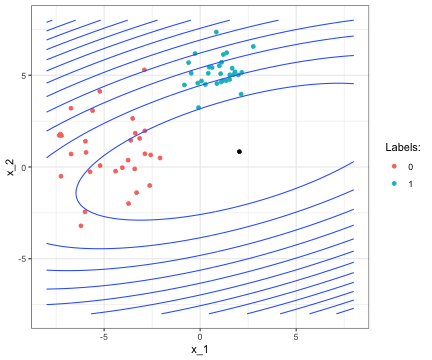

RObject{VecSxp}


In [99]:
nll_grid = -1 .* [logpdf(MvNormal(model.μ,model.Σ),W[n,:]) for n=1:N_grid]
df_grid = DataFrame(hcat(nll_grid,W), :auto)
p + 
    stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1)) +
    geom_point(aes(x=w_map[1], y=w_map[2]))

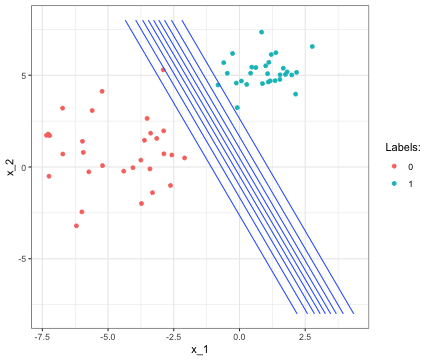

RObject{VecSxp}


In [100]:
y_grid_map = sigmoid(w_map, W) # plugin predictive
df_grid = DataFrame(hcat(y_grid_map,W), :auto)
p + stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1)) 

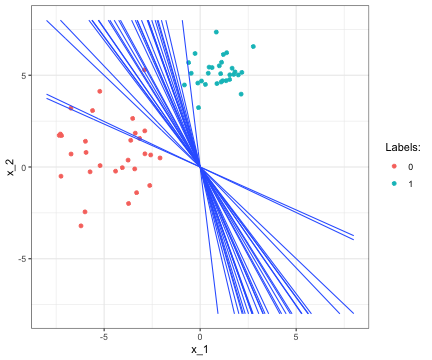

RObject{VecSxp}


In [101]:
p_sample = p
n_sample = 30
W_sample = sample_posterior(model,n_sample)
for i = 1:size(W_sample)[2]
    w_sample = W_sample[:,i]
    y_grid_sample = sigmoid(w_sample, W) # sample predictive
    df_grid = DataFrame(hcat(y_grid_sample,W), :auto)
    p_sample += stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1), bins=2);
end
p_sample

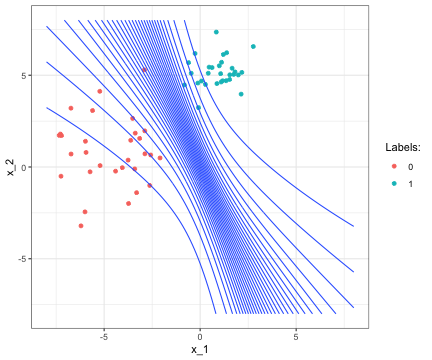

RObject{VecSxp}


In [103]:
y_mc = 1/n_sample .* sigmoid(W_sample, W) * ones(n_sample)
df_grid = DataFrame(hcat(y_mc,W), :auto)
p + stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1), bins=30) 

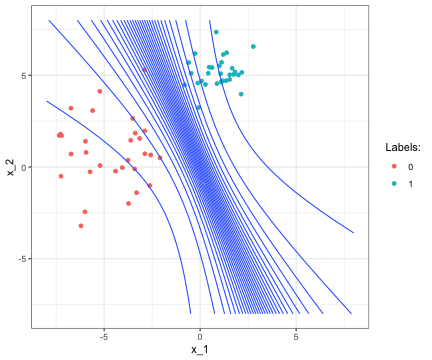

RObject{VecSxp}


In [104]:
y_probit = posterior_predictive(model, W) 
df_grid = DataFrame(hcat(y_probit,W), :auto)
p + stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1), bins=30) 

In [91]:
y_probit

25921-element Vector{Float64}:
 0.0180189932921322
 0.018026517554839694
 0.018034780801916464
 0.018043819493485675
 0.018053672034797026
 0.018064378895386816
 0.018075982736632495
 0.01808852854837566
 0.018102063795347716
 0.018116638574199442
 0.018132305782009868
 0.01814912129723033
 0.018167144174110007
 ⋮
 0.9818508787027697
 0.9818676942179901
 0.9818833614258006
 0.9818979362046523
 0.9819114714516244
 0.9819240172633675
 0.9819356211046132
 0.981946327965203
 0.9819561805065143
 0.9819652191980835
 0.9819734824451604
 0.9819810067078678